# Times Series with GARCH

In [1]:
# Installations 
from arch import arch_model
from statsmodels.tsa.stattools import adfuller,q_stat,acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pandas as pd
import numpy as np 
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import glob
import cufflinks as cf
import scipy
import scipy.stats as stats
import scipy.optimize as sp_optimize
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults
from statsmodels.tsa.statespace.kalman_filter import FilterResults

In [2]:
# Imports
plt.style.use("seaborn")
cf.set_config_file(offline = True)
%matplotlib inline

# Extracting Data from Google Finance
## Step 1
1. Four indices to look at to predict market volatility 
2. preparing out data to be fitted into our model


In [3]:
#Path
Path =  "C:\\Users\\eszczepalink\\Desktop\\GARCH\\Data_Indi_Gar_Var/"

# use glob to read csv's
glob.glob(Path+ "/*.csv")

# Import data and rename Close columns
DJI_DF = pd.read_csv(Path+"DJI - Sheet1.csv", 
            parse_dates = ["Date"],
           index_col = "Date").rename(columns={"Close":"DJI_Close"})
SP_DF = pd.read_csv(Path+"INX - Sheet1.csv",
            parse_dates = ["Date"],
            index_col= "Date").rename(columns={"Close":"SP_Close"})
NQ_DF = pd.read_csv(Path+"IXIC - Sheet1.csv",
            parse_dates = ["Date"],
            index_col = "Date").rename(columns={"Close":"NQ_Close"})
RUT2K = pd.read_csv(Path+"RUT 2k - Sheet1.csv",
            parse_dates= ["Date"],
            index_col= "Date").rename(columns={"Close":"RUT2K_Close"})
RUT3K = pd.read_csv(Path+"RUT 3k - Sheet1.csv",
            parse_dates= ["Date"],
            index_col= "Date").rename(columns={"Close":"RUT3K_Close"})

# Concatenating DF's into volatility df
volatility_df = pd.concat([DJI_DF,SP_DF,NQ_DF,RUT2K,RUT3K], axis=1)


In [4]:
# check info
volatility_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3030 entries, 2010-09-28 16:00:00 to 2022-09-23 16:00:00
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DJI_Close    3012 non-null   float64
 1   SP_Close     3026 non-null   float64
 2   NQ_Close     3019 non-null   float64
 3   RUT2K_Close  3010 non-null   float64
 4   RUT3K_Close  3010 non-null   float64
dtypes: float64(5)
memory usage: 142.0 KB


In [5]:
# check missing value 
volatility_df.isna().sum()

DJI_Close      18
SP_Close        4
NQ_Close       11
RUT2K_Close    20
RUT3K_Close    20
dtype: int64

In [6]:
# delete columns
del volatility_df["RUT3K_Close"]

In [7]:
# using front fill DIJ_Close
volatility_df.DJI_Close = volatility_df.DJI_Close.fillna(method="ffill")

# using front fill SP_Close
volatility_df.SP_Close = volatility_df.SP_Close.fillna(method="ffill")

# using back fill to fill the rest of na's
volatility_df = volatility_df.fillna(method="bfill")

In [8]:
# check is null
volatility_df.isna().sum()

DJI_Close      0
SP_Close       0
NQ_Close       0
RUT2K_Close    0
dtype: int64

In [9]:
# save dataframe to new csv called update 
volatility_df.to_csv("volatility_df_update.csv")

In [10]:
# read our new data fron saved csv
df_indices = pd.read_csv("volatility_df_update.csv",
                        parse_dates=True,
                        infer_datetime_format=True,
                        index_col="Date")

<AxesSubplot:ylabel='Density'>

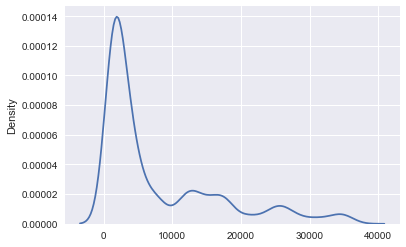

In [11]:
# display density of our data
sns.distplot(df_indices, hist=False, kde=True)

<AxesSubplot:title={'center':'DJI_Close/SP_Close/NQ_Close/RUT2K_Close/RUT3K_Close'}, xlabel='Date'>

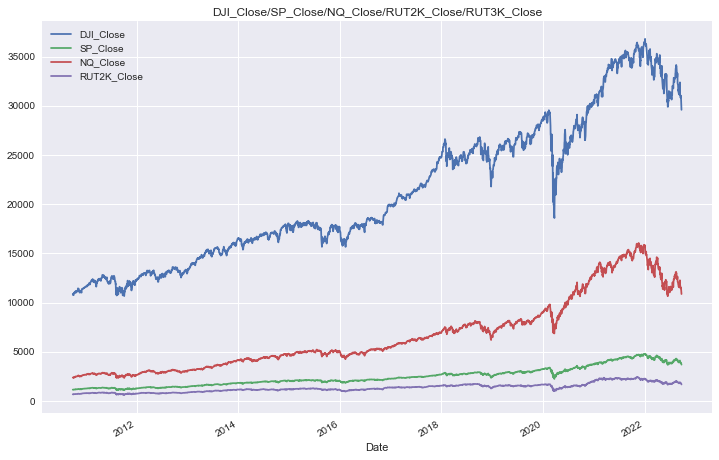

In [12]:
# plot DJI_Close/SP_Close/NQ_Close/RUT2K_Close/RUT3K_Close
df_indices.plot(figsize=(12, 8), title="DJI_Close/SP_Close/NQ_Close/RUT2K_Close/RUT3K_Close")

In [13]:
# Creating Daily Return
df_indices["Return_DJI"] = df_indices["DJI_Close"].pct_change()
df_indices["Return_SP"] = df_indices["SP_Close"].pct_change()
df_indices["Return_NQ"] = df_indices["NQ_Close"].pct_change()
df_indices["Return_RUT2K"] = df_indices["RUT2K_Close"].pct_change()
# dropna's
df_indices.dropna(inplace=True)
# visualizing daily returs 
df_indices[['Return_DJI','Return_SP','Return_NQ','Return_RUT2K']].iplot(title="Returns Indices ",
                                                                           xTitle="Time",
                                                                           yTitle="volatility",
                                                                           theme= "solar")

<AxesSubplot:ylabel='Density'>

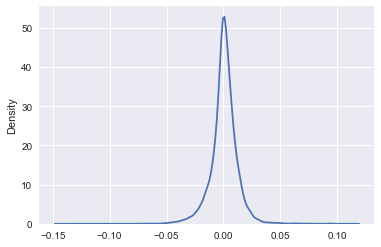

In [14]:
# display returns
sns.distplot(df_indices[['Return_DJI','Return_SP','Return_NQ','Return_RUT2K']], 
                             hist=False, kde=True)

In [15]:
# Calculating rolling std for 5-day window
df_indices["std_DJI"] = df_indices["Return_DJI"].rolling(window=5).std()
df_indices["std_SP"] = df_indices["Return_SP"].rolling(window=5).std()
df_indices["std_NQ"] = df_indices["Return_NQ"].rolling(window=5).std()
df_indices["std_RUT2K"] = df_indices["Return_RUT2K"].rolling(window=5).std()
# dropna's
df_indices.dropna(inplace=True)
# plot volatility of indices
df_indices[["std_DJI","std_SP","std_NQ","std_RUT2K"]].iplot(title="Volatility indices",
                                                                           xTitle="Time",
                                                                           yTitle="volatility",
                                                                           theme= "solar")

In [16]:
# Drop na's
volatility_df.dropna(inplace=True)

In [17]:
# data frame
display(df_indices.head(2))
display(df_indices.tail(2))

,DJI_Close,SP_Close,NQ_Close,RUT2K_Close,Return_DJI,Return_SP,Return_NQ,Return_RUT2K,std_DJI,std_SP,std_NQ,std_RUT2K
Date,,,,,,,,,,,,
2010-10-05 16:00:00,10944.72,1160.75,2399.83,689.35,0.017993,0.020861,0.023591,0.029726,0.010016,0.011277,0.013010,0.016147
2010-10-06 16:00:00,10967.65,1159.97,2373.81,685.33,0.002095,-0.000672,-0.010842,-0.005832,0.009798,0.011100,0.014216,0.016778


,DJI_Close,SP_Close,NQ_Close,RUT2K_Close,Return_DJI,Return_SP,Return_NQ,Return_RUT2K,std_DJI,std_SP,std_NQ,std_RUT2K
Date,,,,,,,,,,,,
2022-09-22 16:00:00,30076.68,3757.99,11066.81,1722.31,-0.003548,-0.008428,-0.013670,-0.022614,0.008658,0.008857,0.009684,0.011552
2022-09-23 16:00:00,29590.41,3693.23,10867.93,1679.59,-0.016168,-0.017233,-0.017971,-0.024804,0.009741,0.009870,0.010586,0.013040


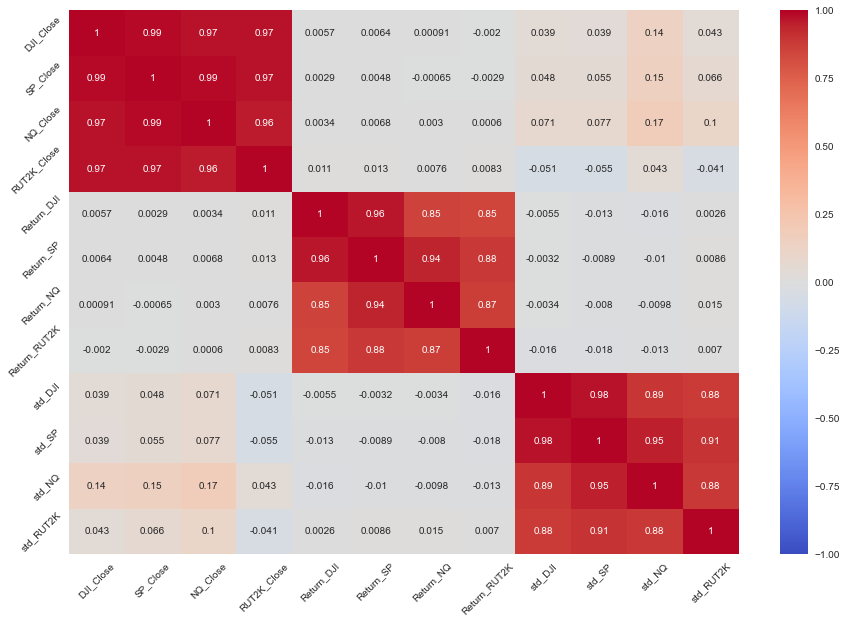

In [18]:
# plot heatmap
fig, ax = plt.subplots(figsize=(15,10)) 
sns.heatmap(df_indices.corr(),
           annot = True,
           vmin=-1,
           vmax=1,
           cmap="coolwarm",
           annot_kws={'size': 10})
           
plt.xticks(rotation=45);
plt.yticks(rotation=45);

# Step 2
## Check for Stationarity 
1. A Stationary in time series is one whose mean and variance does not change over time
2. perform augmentation testing Dickey-Fuller Test (ADF Test)
- Ho (Null Hypothesis): The time series data is non-stationary
- H1 (alternate Hypothesis): The time series data is stationary
- p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
- p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.



In [19]:
# creating a new data frame for returns on indices 
df_indices_return = df_indices[['Return_DJI','Return_SP','Return_NQ','Return_RUT2K']]

# save a new dataframe into a new cvs called indices return 
df_indices_return.to_csv("df_indices_return.csv")


In [20]:
# reset date column
df_indices_return.reset_index("Date")

# save a dataframe to new csv called Dickey_Fuller 
df_indices_return.to_csv("Dickey-Fuller.csv")

# set header and index_col = 0
df_update = pd.read_csv("Dickey-Fuller.csv", header=0, index_col=0)

# get values of our dataframe then reshape it to 1 dimentional array to be fitted into adfuller model 
values = df_update.values.reshape(-1)

# results 
res = adfuller(values)

# print results 
print('Augmneted Dickey_fuller Statistic: %f' % res[0])
print('p-value: %f' % res[1])
print('critical values at different levels:')
for k, v in res[4].items():
    print('\t%s: %.3f' % (k, v))

Augmneted Dickey_fuller Statistic: -17.947147
p-value: 0.000000
critical values at different levels:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [21]:
'''
our results show that Dickey_fuller Statistic is greater than critical values of 1%,5%,10% 
p-value is less than 0.05
so, we proved the stationarity 

'''

'\nour results show that Dickey_fuller Statistic is greater than critical values of 1%,5%,10% \np-value is less than 0.05\nso, we proved the stationarity \n\n'

# Apply ACF,PACF plot to find the right q, p?

In [22]:
# check autocorrelation 
df_indices["DJI_Close"].autocorr()


0.9994205670737429

In [23]:
# check autocorrelation for closing prices
df_indices["Return_DJI"].autocorr()

-0.1420799763438997

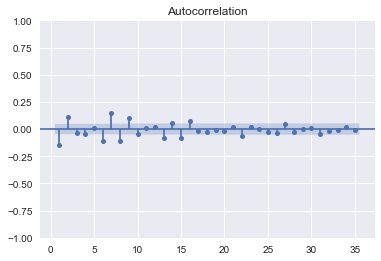

In [24]:
# plot acf for return_DJI
plot_acf(df_indices["Return_DJI"], zero = False,alpha=0.01)
plt.show()

In [25]:
 # apply diff method to chose right d to compared to acf pot therefor chosing the right q
df_indices["diff"] = df_indices["Return_DJI"].diff()

# dropna
df_indices["diff"].dropna(inplace=True)

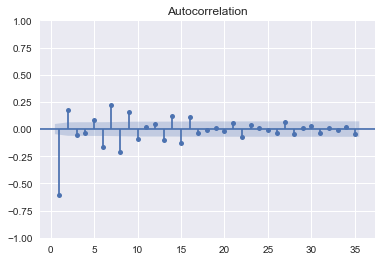

In [26]:
# plot diff 
plot_acf(df_indices["diff"][1:],zero = False, alpha=0.01)
plt.show()

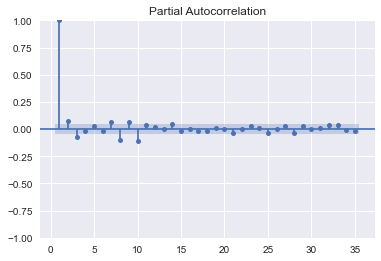

In [27]:
# plot pacf then compare it with pacf diff plot to chose the right p
plot_pacf(df_indices["DJI_Close"],zero = False, alpha=0.01)
plt.show()

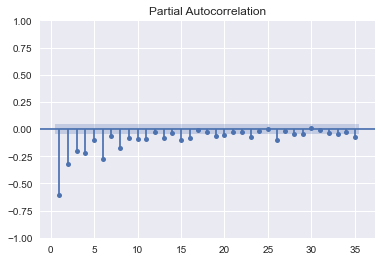

In [28]:
# pacf plot for diff 
plot_pacf(df_indices["diff"][1:],zero = False, alpha=0.01)
plt.show()

# Calculating volatility for DJI

In [29]:
# Calculate daily std of returns
std_daily = df_indices_return['Return_DJI'].std()

print(f'Daily volatility: {round(std_daily,5)}%')

# Convert daily volatility to monthly volatility
std_monthly = np.sqrt(21) * std_daily

print(f'\nMonthly volatility: {round(std_monthly,5)}%')

# Convert daily volatility to annaul volatility
std_annual = np.sqrt(252) * std_daily

print(f'\nAnnual volatility: {round(std_annual,5)}%')


Daily volatility: 0.0108%

Monthly volatility: 0.04948%

Annual volatility: 0.17139%


## Fit a Garch model ()  since we assumed our data is stationary
-  p = ?, q = ?

## Resample data by weekly return to get futher forcasting 

In [30]:
# Using Returns dataframe to creating Garch dataframe 
df_indices_return.head()

# Creating Garch dataframe of 5 day window by apply mean()
df_Garch = df_indices_return.rolling(window=5).mean()

# dropna's
df_Garch.dropna(inplace=True)

# resample by weekly 
df_Garch = df_Garch.resample('W').mean()

# check if there is na's
df_Garch.isnull().sum()

# save a new dataframe into new csv's

df_Garch.to_csv("df_Grach_W.csv")

# data frame
display(df_Garch.head(2))
display(df_Garch.tail(2))

,Return_DJI,Return_SP,Return_NQ,Return_RUT2K
Date,,,,
2010-10-17,0.002440,0.002847,0.004386,0.004775
2010-10-24,0.000846,0.001019,0.002482,0.000304


,Return_DJI,Return_SP,Return_NQ,Return_RUT2K
Date,,,,
2022-09-18,-0.001855,-0.001047,-0.000819,0.000972
2022-09-25,-0.006196,-0.007815,-0.008601,-0.009606


# Implement a basic GARCH model
1. to implement a GARCH(p,q) model:
- First defines basic GRACH(p,q) model
- then fit model
- review the model fitting summary and plot the results

In [31]:
# Using for loop to make a guess finding right p,q
for p in range(3):
    for q in range(3):
        if p == 0 and q == 0:
            continue
            
        print(f'Testing Order: p = {p}, q = {q}')

Testing Order: p = 0, q = 1
Testing Order: p = 0, q = 2
Testing Order: p = 1, q = 0
Testing Order: p = 1, q = 1
Testing Order: p = 1, q = 2
Testing Order: p = 2, q = 0
Testing Order: p = 2, q = 1
Testing Order: p = 2, q = 2


Iteration:      5,   Func. Count:     72,   Neg. LLF: 300834406206235.4
Iteration:     10,   Func. Count:    153,   Neg. LLF: 1664662579.2716298
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2710.6453726759055
            Iterations: 15
            Function evaluations: 167
            Gradient evaluations: 11
                     Constant Mean - GARCH Model Results                      
Dep. Variable:             Return_DJI   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                2710.65
Distribution:                  Normal   AIC:                          -5409.29
Method:            Maximum Likelihood   BIC:                          -5382.67
                                        No. Observations:                  624
Date:                Tue, Oct 04 2022   Df Residuals:                      623
Time:      

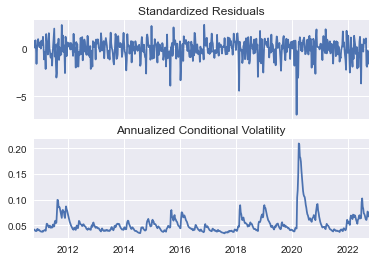

In [32]:
#GARCH model with constant mean
model_garch_indices = arch_model(df_Garch['Return_DJI'], p = p, q = q,
                      mean = 'constant', vol = 'GARCH', dist = 'normal')
# Fit the model                  freq to avoid display unnecessary value
result_indices = model_garch_indices.fit(update_freq = 5)
 

# Display model fitting summary
print(result_indices.summary())


# Plot fitted results
result_indices.plot(annualize='D')
plt.show()


# Make forecast with GARCH models

                h.1       h.2      h.3      h.4       h.5
Date                                                     
2022-09-25  0.00002  0.000021  0.00002  0.00002  0.000019


<AxesSubplot:>

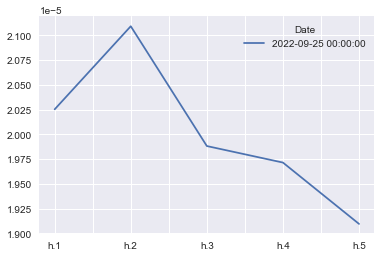

In [33]:
# horizon = how many observations we want our model to predict for each day 
# for each date, we'll get the predicted value, for the next date
pred_grach = result_indices.forecast(start = "2022-09-23",horizon= 5)
# prediction value for next weeks
print(pred_grach.variance[-1:])
# plot prediction
pred_grach.variance[-1:].T.plot()

# Distribution assumptions
1. Volatility is not directly observed
2. GARCH model use residuals as volatilty shocks
3. Volatility is related to the residuals
### Residual = predicted return - mean return
  - Residual = predicted return - mean return
 
  - Standardized residual = residual / return volatility


# Plot distribution of standardized residuals

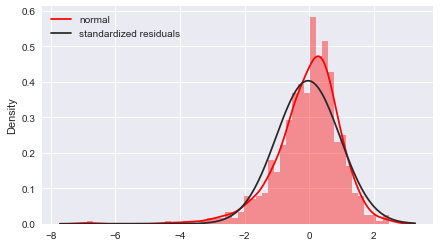

In [34]:
# residuals and volatility
model_indices_resid = result_indices.resid
model_indices_std = result_indices.conditional_volatility

# Calculate the standardized residuals
result_indices_std = model_indices_resid /model_indices_std

# Plot the histogram of the standardized residuals
plt.figure(figsize=(7,4))
sns.distplot(result_indices_std, norm_hist=True, fit=stats.norm, bins=50, color='r')
plt.legend(('normal', 'standardized residuals'))
plt.show()


# Fit a GARCH with skewed t-distribution
- We improve the GARCH model by using a skewed t-distribution

In [35]:
# Garch model skewt
model_garch_indices = arch_model(df_Garch['Return_DJI'], p = p, q = q,
                       mean = 'constant', vol = 'GARCH', dist = 'skewt')

# fit the model
model_garch_indices_result = model_garch_indices.fit(disp='off')

# get estimated volatility 
vol_Grch_model = model_garch_indices_result.conditional_volatility

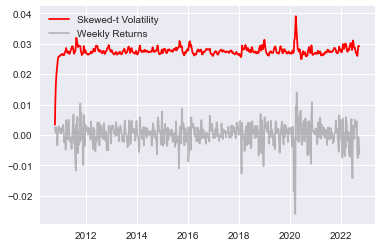

In [36]:
# Plot model fitting results
plt.plot(vol_Grch_model, color = 'red', label = 'Skewed-t Volatility')
plt.plot(df_Garch['Return_DJI'], color = 'grey', 
         label = 'Weekly Returns', alpha = 0.5)
plt.legend(loc = 'upper left')
plt.show()

# Goodness of fit

1. Maximun likelihood
2. Lower Criteria (AIC, BIC)

In [37]:
# Print the Criteria (BIC) (AIC) of GARCH
print(f'GARCH BIC : { result_indices.bic}')
print(f'GARCH AIC : { result_indices.aic}')

# Print the log-likelihodd of GARCH
print('Log-likelihood of GARCH :', result_indices.loglikelihood)
# Print the log-likelihodd of skewt GARCH
print('Log-likelihood of skewt GARCH :', model_garch_indices_result.loglikelihood)

GARCH BIC : -5382.673843141594
GARCH AIC : -5409.290745351811
Log-likelihood of GARCH : 2710.6453726759055
Log-likelihood of skewt GARCH : 1121.9321982309464


# Backtesting with MAE, MSE

-  Out of sample forecast

In [38]:
def evaluate(y_true, y_pred): 
    # calculate MAE
    mae = mean_absolute_error(y_true, y_pred)
    print(f'Mean Absolute Error (MAE): {round(mae,3)}')
    # calculate MSE
    mse = mean_squared_error(y_true, y_pred)
    print(f'Mean Squared Error (MSE): {round(mse,3)}')
    return mae, mse

In [39]:
# weekly resample, apply std then calculate y_true, y_pred
indices_return_std = df_indices_return['Return_DJI'].rolling(window=5).std()
indices_return_std.dropna().resample('W').std()

y_true = indices_return_std.dropna().resample('W').std()
y_pred = model_indices_std

In [40]:
# print out mse
mean_squared_error(y_true,y_pred)

4.531640072194343e-06

In [41]:
# print out mae
mean_absolute_error(y_true,y_pred)

0.0018073197926565924

# Time Series with  VarMax

In [42]:
# Importing Modules 
import pandas as pd
import numpy as np
import yfinance as yf
import datetime as dt


In [43]:
# use yahoo finance
ticker = yf.Ticker('^DJI')
df_DJI = ticker.history(period="12y")
# compute stdev
stdev_window = 25
df_DJI['stdev'] = df_DJI['Close'].pct_change().rolling(stdev_window).std()

df_DJI.dropna(inplace=True)
print(df_DJI.shape)
display(df_DJI.head())

(2997, 8)


,Open,High,Low,Close,Volume,Dividends,Stock Splits,stdev
Date,,,,,,,,
2010-11-08,11439.540039,11439.610352,11362.530273,11406.839844,143990000,0,0,0.006941
2010-11-09,11403.589844,11421.139648,11303.190430,11346.750000,161910000,0,0,0.006292
2010-11-10,11342.809570,11366.160156,11255.019531,11357.040039,164170000,0,0,0.006291
2010-11-11,11326.690430,11326.769531,11231.219727,11283.099609,296660000,0,0,0.006461
2010-11-12,11281.280273,11283.700195,11143.839844,11192.580078,217650000,0,0,0.006658


In [44]:
# Check stationarity
# fix stationarity by apply log and diff
df_transformed = pd.DataFrame({'Open': np.log(df_DJI.Open).diff(),
                              'High': np.log(df_DJI.High).diff(),
                               'Low': np.log(df_DJI.Low).diff(),
                               'Close': np.log(df_DJI.Close).diff(),
                               'stdev': np.log(df_DJI.stdev).diff()
                                                                                         
                              }).dropna()
display(df_transformed.head())

,Open,High,Low,Close,stdev
Date,,,,,
2010-11-09,-0.003148,-0.001616,-0.005236,-0.005282,-0.098257
2010-11-10,-0.005344,-0.004825,-0.004271,0.000906,-0.000077
2010-11-11,-0.001422,-0.003472,-0.002117,-0.006532,0.026629
2010-11-12,-0.004017,-0.003810,-0.007811,-0.008055,0.029980
2010-11-15,-0.007765,-0.000248,0.004053,0.000839,-0.000049


In [45]:
# reset date column
df_transformed.reset_index("Date")

# save a dataframe to new csv called garch 
df_transformed.to_csv("varmax.csv")

# set header and index_col = 0
df_transformed_garch = pd.read_csv("varmax.csv", header=0, index_col=0)

#get values of our dataframe then reshape it to 1 dimentional array to be fitted into adfuller model 
values = df_transformed_garch.values.reshape(-1)

# results 
res = adfuller(values)

# print results 
print('Augmneted Dickey_fuller Statistic: %f' % res[0])
print('p-value: %f' % res[1])
print('critical values at different levels:')
for k, v in res[4].items():
    print('\t%s: %.3f' % (k, v))

Augmneted Dickey_fuller Statistic: -23.709713
p-value: 0.000000
critical values at different levels:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [46]:
# apply train test split 
split = int(len(df_transformed) * 0.70)
df_train, df_test = df_transformed.iloc[:split], df_transformed.iloc[split:]
print(df_train.info())  
print(df_test.info()) 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2097 entries, 2010-11-09 to 2019-03-12
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2097 non-null   float64
 1   High    2097 non-null   float64
 2   Low     2097 non-null   float64
 3   Close   2097 non-null   float64
 4   stdev   2097 non-null   float64
dtypes: float64(5)
memory usage: 98.3 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 899 entries, 2019-03-13 to 2022-10-04
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    899 non-null    float64
 1   High    899 non-null    float64
 2   Low     899 non-null    float64
 3   Close   899 non-null    float64
 4   stdev   899 non-null    float64
dtypes: float64(5)
memory usage: 42.1 KB
None


In [47]:
# Using for loop to make a guess finding right p,q
for p in range(3):
    for q in range(3):
        if p == 0 and q == 0:
            continue
            
        print(f'Testing Order: p = {p}, q = {q}')

Testing Order: p = 0, q = 1
Testing Order: p = 0, q = 2
Testing Order: p = 1, q = 0
Testing Order: p = 1, q = 1
Testing Order: p = 1, q = 2
Testing Order: p = 2, q = 0
Testing Order: p = 2, q = 1
Testing Order: p = 2, q = 2


In [48]:
#GARCH model with constant mean
model = VARMAX(df_test, order=(p,q)).fit()
print(model.summary())


                                       Statespace Model Results                                      
Dep. Variable:     ['Open', 'High', 'Low', 'Close', 'stdev']   No. Observations:                  899
Model:                                            VARMA(2,2)   Log Likelihood               14750.186
                                                 + intercept   AIC                         -29260.373
Date:                                       Tue, 04 Oct 2022   BIC                         -28684.219
Time:                                               12:17:21   HQIC                        -29040.266
Sample:                                                    0                                         
                                                       - 899                                         
Covariance Type:                                         opg                                         
Ljung-Box (L1) (Q):     1.19, 0.54, 0.17, 6.10, 0.00   Jarque-Bera (JB):   34416.5

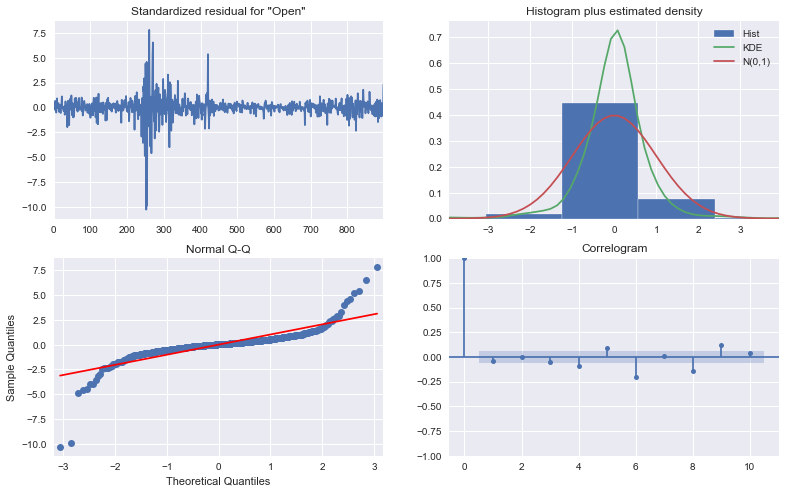

In [49]:
model.plot_diagnostics(figsize=(13,8))
plt.show()

# Get Prediction

In [50]:
# pred = model.predict(start=2097, end=len(df_transformed)-1)
# preds.index = df_transformed.index[2097:]
# pred["observed"] =df_transformed.iloc[2097:].set_index(df_transformed.index[2096:]).stdev.plot()

# forecast


In [51]:
forecast = model.forecast(steps=100)

In [52]:
mean_absolute_error(forecast, df_transformed.iloc[-100:])


0.013123202169560316

In [53]:
mean_squared_error(forecast,df_transformed.iloc[-100:])

0.0005484228741084497